In [1]:
from vnstock import *
from Tools.function import *
from Tools.operators import *
from Tools.technical import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests

##### VN30

In [3]:
x='2023-02-16'
ticket = ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'MBB', 'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'POW', 'SAB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']
frame = []
for i in ticket:
    a = stock_historical_data(symbol=i, 
                            start_date=x,
                            end_date=x)
    a["ticker"] = i
    frame.append(a)
    
q = pd.concat(frame)
close= q.pivot_table(values="Close", columns="ticker", index="TradingDate")
high= q.pivot_table(values="High", columns="ticker", index="TradingDate")
low= q.pivot_table(values="Low", columns="ticker", index="TradingDate")
open= q.pivot_table(values="Open", columns="ticker", index="TradingDate")
volume = q.pivot_table(values="Volume", columns="ticker", index="TradingDate")

In [2]:
close= close.to_csv("Data/close.csv",mode="a",header=False)
high= high.to_csv("Data/high.csv",mode="a",header=False)
low= low.to_csv("Data/low.csv",mode="a",header=False)
open= open.to_csv("Data/open.csv",mode="a",header=False)
volume= volume.to_csv("Data/volume.csv",mode="a",header=False)

In [2]:
close= pd.read_csv("Data/close.csv",index_col="TradingDate")
close.index = pd.to_datetime(close.index)
high= pd.read_csv("Data/high.csv",index_col="TradingDate")
high.index = pd.to_datetime(high.index)
low= pd.read_csv("Data/low.csv",index_col="TradingDate")
low.index = pd.to_datetime(low.index)
open= pd.read_csv("Data/open.csv",index_col="TradingDate")
open.index = pd.to_datetime(open.index)
volume= pd.read_csv("Data/volume.csv",index_col="TradingDate")
volume.index = pd.to_datetime(open.index)

returns = close.pct_change()

### Prob weight model

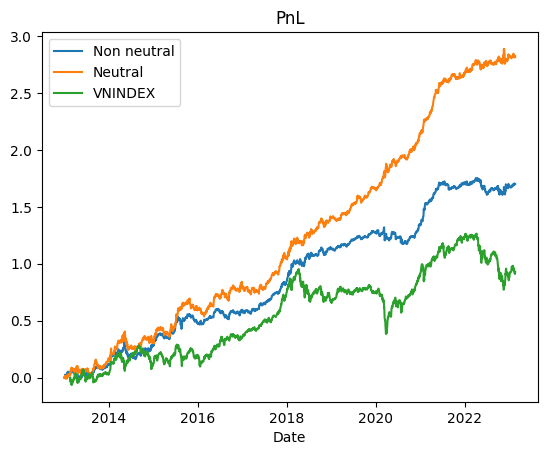

In [37]:
prob = prob_weights(volume,5)

w = weights(prob,neutrali=0)
w1 = weights(prob,neutrali=1)

a = Simresult(w,returns=returns)
a.plot_pnl("Non neutral")

b = Simresult(w1,returns=returns)
b.plot_pnl("Neutral")

plot_vnindex()

In [38]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.281508,1.862172,2.182994,0.668712,128.954925


### Markowitz model

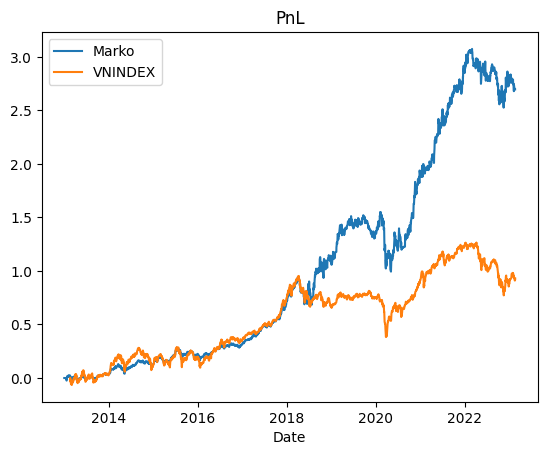

In [6]:
mark = marko_weights(close,lag=10)
a = Simresult(mark,returns=close.pct_change())
a.plot_pnl("Marko")

plot_vnindex()

In [7]:
a.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,0.037903,0.521421,0.000000,0.287124,inf
2014,0.091851,1.054659,0.000000,0.904066,inf
2015,0.093926,0.960856,0.000000,0.832907,inf
2016,0.098835,1.235096,0.000000,1.098247,inf
2017,0.396302,4.764245,0.000000,8.483056,inf
2018,0.408062,0.991476,0.095467,1.791391,4274.389310
2019,0.256358,0.918631,0.200000,1.040039,1281.791139
2020,0.545455,1.140511,0.174603,2.015825,3123.971292
2021,0.981200,2.277145,0.182531,5.279598,5375.519063


### volum/adv20

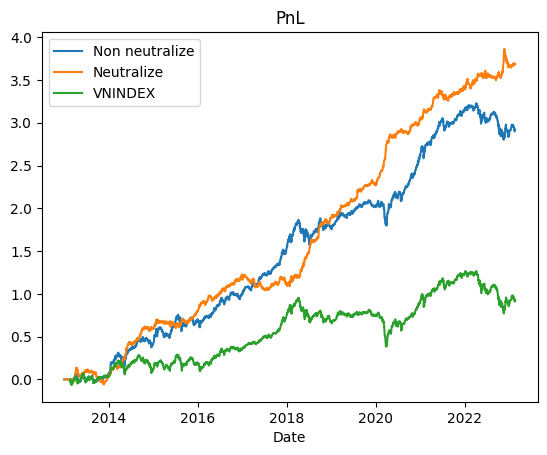

In [42]:
alpha1 = volume/ts_mean(ts_decay_linear(volume,30),20)
w =weights(alpha1, neutrali=0)
w1 =weights(alpha1,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [23]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.367605,2.267487,1.404202,1.160167,261.789134


##### rank(alpha)

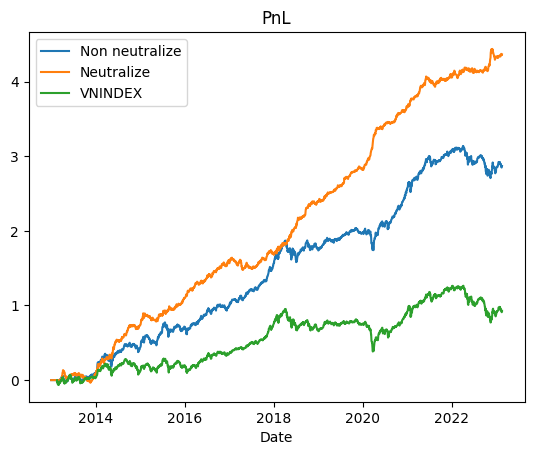

In [32]:
alpha5 = rank(alpha1)

w =weights(alpha5, neutrali=0)
w1 =weights(alpha5,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [33]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.435499,2.782407,1.570546,1.465172,277.291149


##### MAE

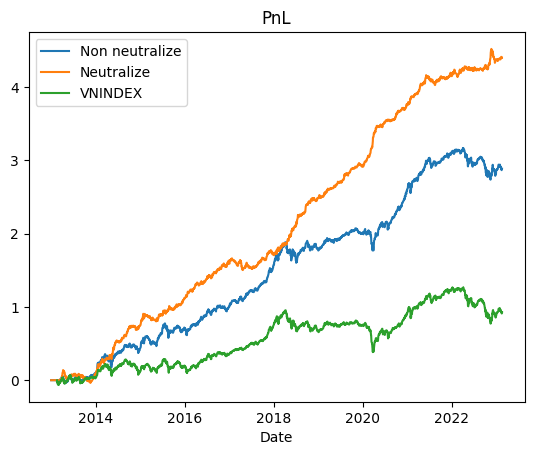

In [5]:
alpha = mae(alpha5)
w =weights(alpha, neutrali=0)
w1 =weights(alpha,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [6]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.439098,2.764002,1.572852,1.460411,279.173085


##### KST

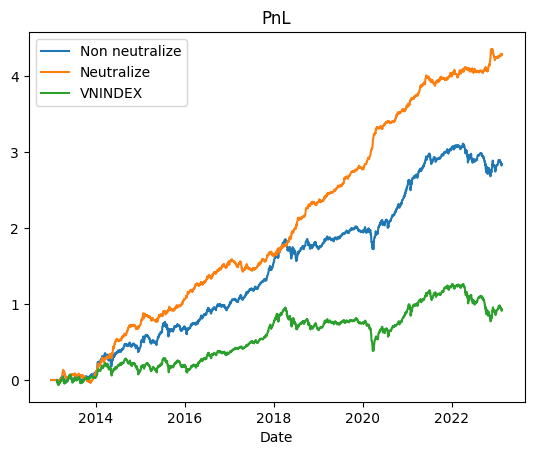

In [7]:
alpha = kst(alpha5)
w =weights(alpha, neutrali=0)
w1 =weights(alpha,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [8]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.427743,2.732649,1.586574,1.418879,269.601873


##### MACD

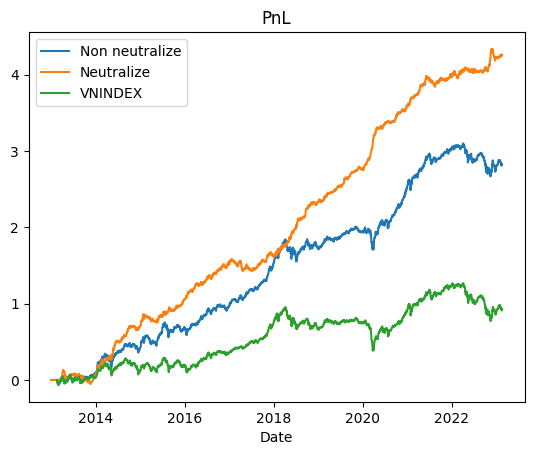

In [9]:
alpha = macd(alpha5)
w =weights(alpha, neutrali=0)
w1 =weights(alpha,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [10]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.424401,2.718982,1.586335,1.406362,267.535504


##### MACD hist

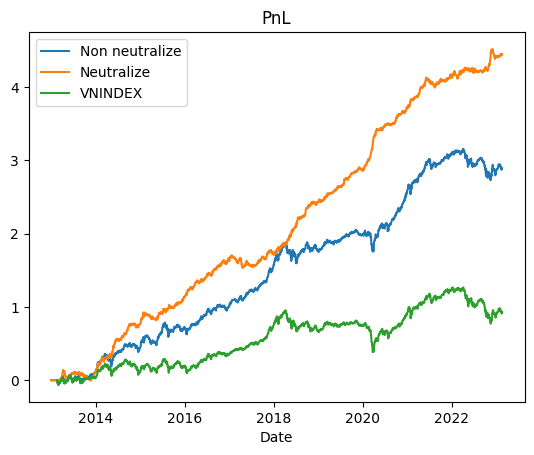

In [43]:
alpha = rank(macd_his(alpha1))
w =weights(alpha, neutrali=0)
w1 =weights(alpha,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [44]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.44375,2.83482,1.559914,1.511975,284.470955


##### Save weight

In [16]:
w1.iloc[-1,:].sort_values(ascending=False)

VIC    0.128889
HDB    0.120000
VHM    0.111111
POW    0.102222
GAS    0.093333
PLX    0.084444
HPG    0.075556
STB    0.066667
CTG    0.057778
BVH    0.048889
NVL    0.040000
BCM    0.031111
BID    0.022222
VPB    0.013333
VCB    0.004444
ACB   -0.004444
SSI   -0.013333
TPB   -0.022222
VIB   -0.031111
GVR   -0.040000
MSN   -0.048889
MBB   -0.057778
FPT   -0.066667
TCB   -0.075556
MWG   -0.084444
VRE   -0.093333
VJC   -0.102222
VNM   -0.111111
PDR   -0.120000
SAB   -0.128889
Name: 2023-02-16 00:00:00, dtype: float64

In [12]:
save_weights(w1,x)